In [2]:
import lib_eval as eval
import pickle as pk
import pandas as pd
import numpy as np
from numpy import *
import time
import matplotlib.pyplot as plt
from tqdm import *
from pylab import *
from multiprocessing import Pool
import pickle
import os
import julian
import torch
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
from scipy.stats import multivariate_normal as mn
nasa_julian = 98
cnes_julian = 90

## I. Predict temperature surface in the Gulf Stream region (pressure < 100)


### Load coordinates, dates

In [3]:
coords_g =  pd.read_pickle('data/GS-p_100/features_gs_100.pkl')
lat, lon, juld = coords_g[:,0],coords_g[:,1],coords_g[:,2]
map = Basemap(projection='merc',llcrnrlat=30,urcrnrlat=50,llcrnrlon=-75,urcrnrlon=-35,resolution='c')

#### Plot the ground truth surface temperature

In [4]:
gt_temp = pd.read_pickle('data/GS-p_100/y_train_gs_100.pkl')[:,0]

In [5]:
# temp_plot(lon,lat,map,gt_temp)

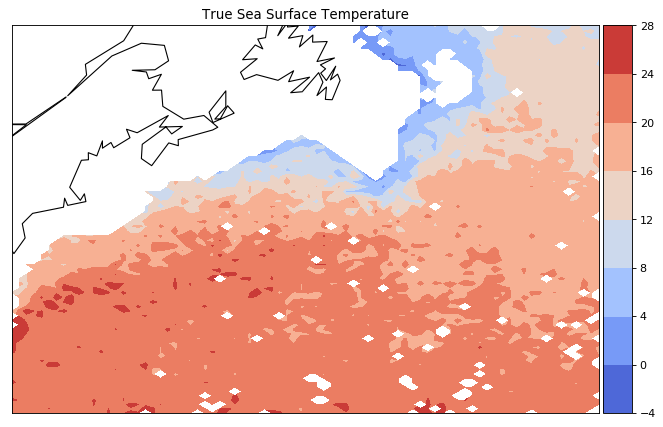

In [7]:
eval.pcolor_surface(lon, lat, 80, 80, map, gt_temp, title = 'True Sea Surface Temperature')

#### Plot the estimated surface temperature

In [8]:
est_temp = np.loadtxt('trained-model/GS-p_100/y_hat_1_4_gs100.txt')

In [13]:
# temp_plot(lon,lat,map,est_temp)

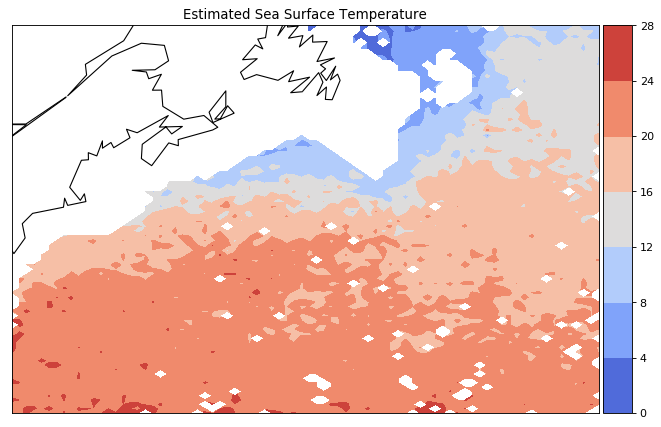

In [9]:
eval.pcolor_surface(lon, lat, 80, 80, map, est_temp, title = 'Estimated Sea Surface Temperature')

#### Residual plot of temperature

In [10]:
residual_temp = abs(est_temp-gt_temp)

In [11]:
from sklearn.metrics import r2_score
# calculate r2 score
r2_score(gt_temp, est_temp)

0.93169063419805

In [17]:
# temp_plot(lon,lat,map,residual_temp)

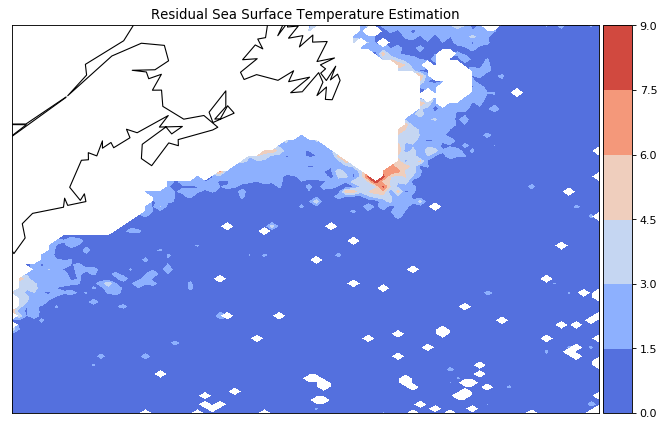

In [12]:
eval.pcolor_surface(lon, lat, 80, 80, map, residual_temp, title = 'Residual Sea Surface Temperature Estimation')

#### Plot the dominant mode for each profile on the maps

In [17]:
pi_hat = np.loadtxt('trained-model/GS-p_100/pi_hat_1_4_gs100.txt')

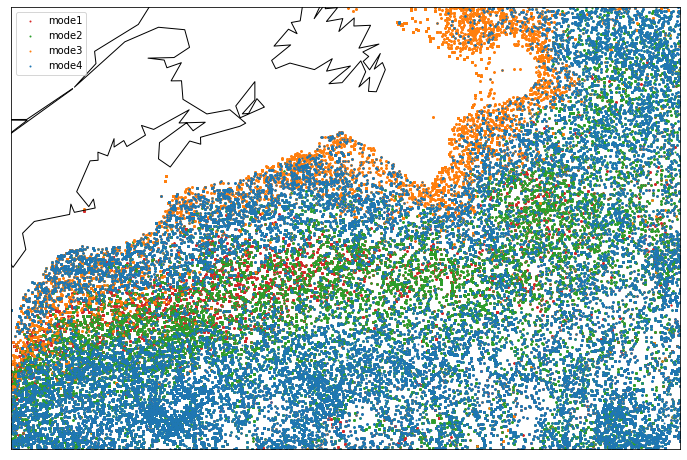

In [20]:
eval.mode_dist(lon,lat,map,pi_hat)

#### Plot the prorior mode probabilities varying in time

<Figure size 720x432 with 0 Axes>

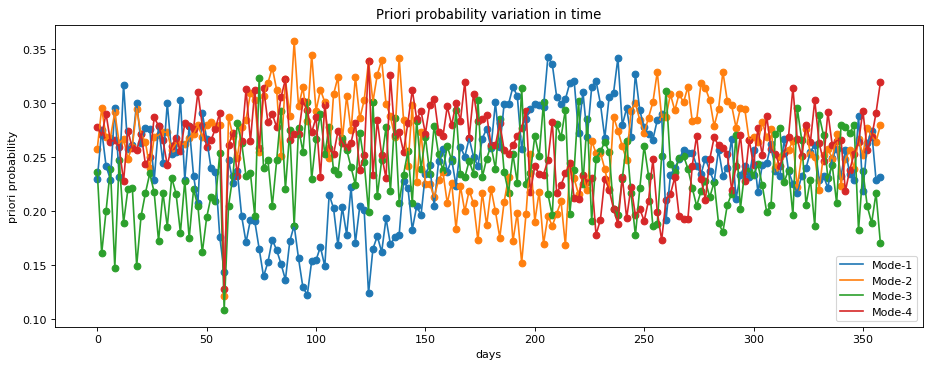

In [45]:
eval.prior_prob_time_plot(pi_hat,juld, 4,2, figx =14, figy = 5)

#### Following the temperature evolution of a point in the Gulf Stream region

In [16]:
X = pd.read_pickle("data/GS-p_100/x_train_gs_100.pkl")

test_info = pd.read_pickle("trained-model/GS-p_100/test1_info_gs100.pkl")
# feature mean
f_x = test_info["feature_mean"]
# feature std
std_x = test_info["feature_std"]

beta = pd.read_pickle("trained-model/GS-p_100/beta1_4_gs100.pkl")
lambda_ = pd.read_pickle("trained-model/GS-p_100/lambda1_4_gs100.pkl")
sigma = pd.read_pickle("trained-model/GS-p_100/sigma1_4_gs100.pkl")
profiles = pd.read_pickle('data/GS-p_100/features_gs_100.pkl')[:,-1]

In [88]:
index = 2000
priode_ = 365*6 # days
prof = profiles[index]
daysx,tempx = eval.follow_x(index,coords_g,priode_,X,f_x,std_x,pi_hat,beta,lambda_,sigma,gt_temp)

Coordinates x:  (longtitude= -42.18899917602539,latitude= 34.55799865722656)


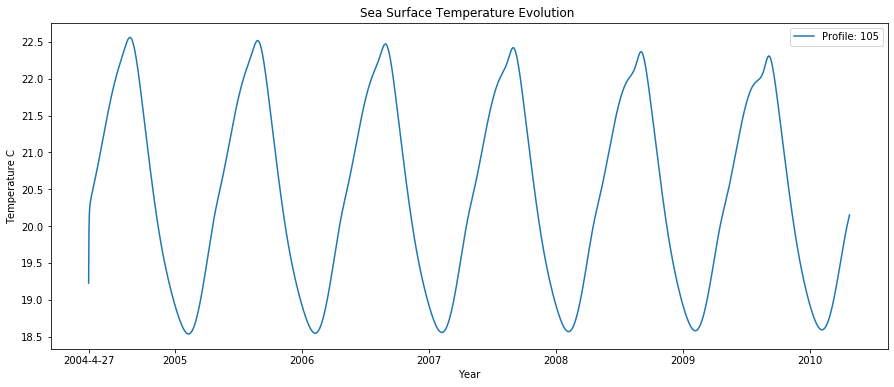

In [89]:
eval.follow_x_plot(daysx,tempx,int(prof),step = 1)

In [90]:
index = 10000
priode_ = 365*20 # days
prof = profiles[index]
daysx,tempx = eval.follow_x(index,coords_g,priode_,X,f_x,std_x,pi_hat,beta,lambda_,sigma,gt_temp)

Coordinates x:  (longtitude= -43.19200134277344,latitude= 34.4379997253418)


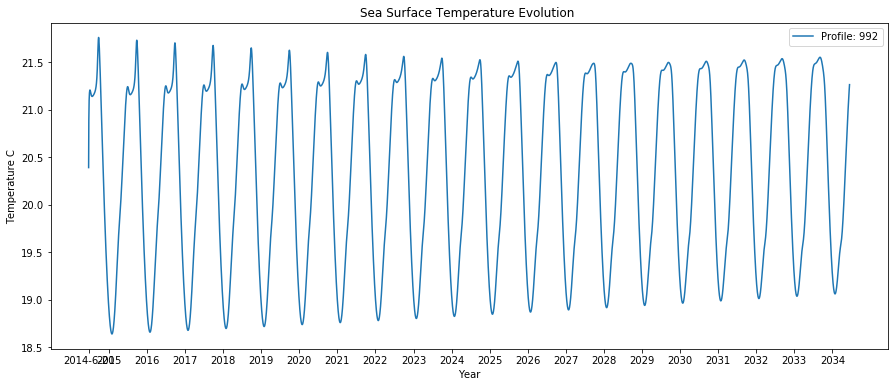

In [91]:
eval.follow_x_plot(daysx,tempx,int(prof),step = 1)

## II. Predict temperature surface in the KUROSHIO region (pressure < 100, 10% data)

### Load coordinates, dates

In [92]:
coords_g2 =  pd.read_pickle('feature_train_ks100_10.pkl')
lat2, lon2, juld2 = coords_g2[:,0],coords_g2[:,1],coords_g2[:,2]
map = Basemap(projection='merc',llcrnrlat=25,urcrnrlat=45,llcrnrlon=132,urcrnrlon=180,resolution='c')

#### Plot the ground truth surface temperature

In [29]:
gt_temp2 = pd.read_pickle('y_train_ks100_10.pkl')[:,0]

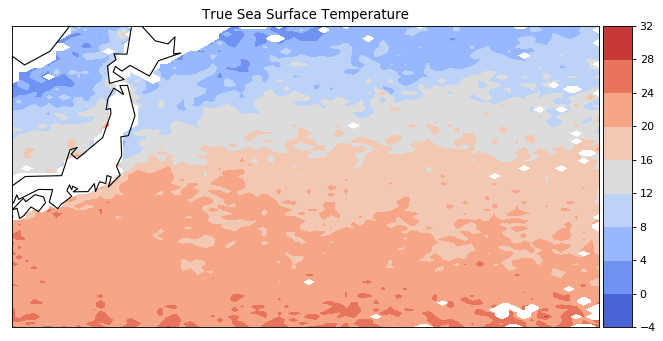

In [30]:
pcolor_surface(lon2, lat2, 80, 80, map, gt_temp2, title = 'True Sea Surface Temperature')

#### Plot the estimated surface temperature

In [31]:
est_temp2 = np.loadtxt('y_hat2_5_ks_100_10.txt')

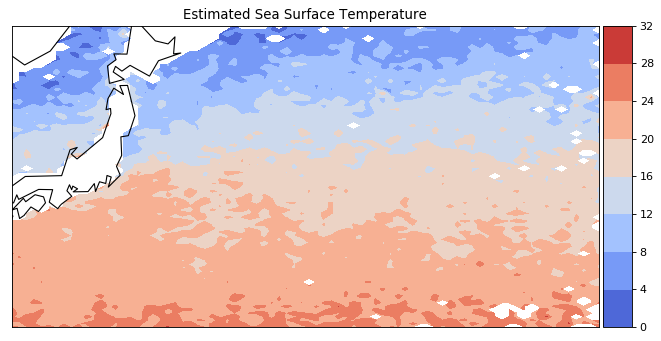

In [32]:
pcolor_surface(lon2, lat2, 80, 80, map, est_temp2, title = 'Estimated Sea Surface Temperature')

#### Residual plot of temperature

In [33]:
residual_temp2 = abs(est_temp2-gt_temp2)

In [34]:
from sklearn.metrics import r2_score
# calculate r2 score
r2_score(gt_temp2, est_temp2)

0.9798151424849587

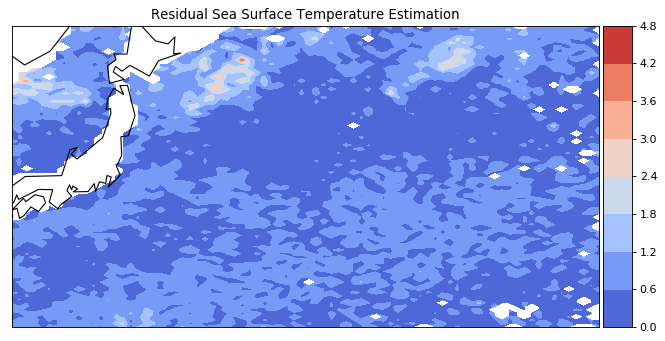

In [35]:
pcolor_surface(lon2, lat2, 80, 80, map, residual_temp2, title = 'Residual Sea Surface Temperature Estimation')

#### Plot the dominant mode for each profile on the maps

In [36]:
pi_hat2 = np.loadtxt('pi_hat_2_5_ks100_10.txt')

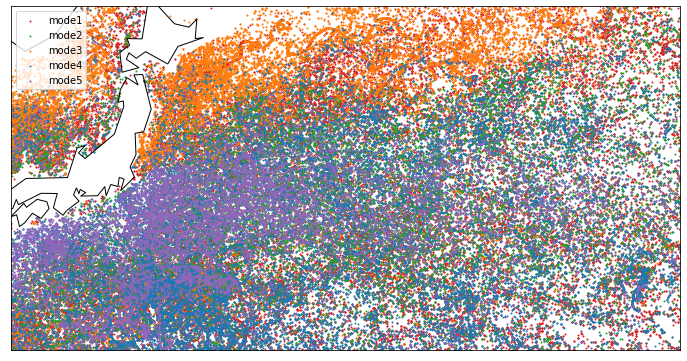

In [37]:
mode_dist(lon2,lat2,map,pi_hat2)

#### Plot the prorior mode probabilities varying in time

<Figure size 720x432 with 0 Axes>

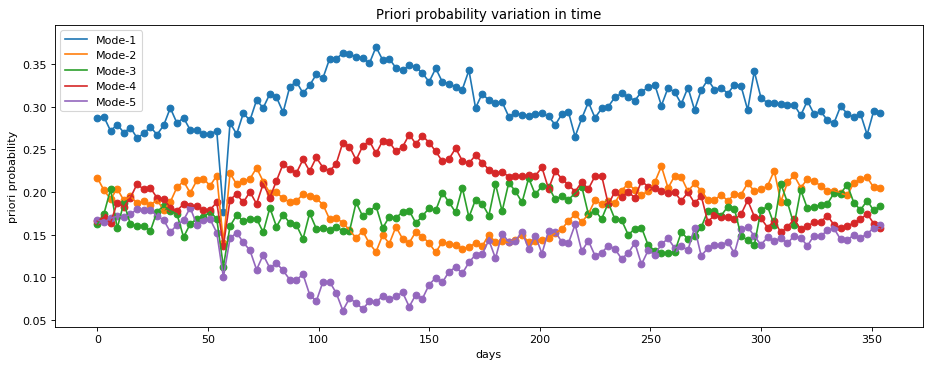

In [46]:
prior_prob_time_plot(pi_hat2,juld2, K = 5, m = 3, figx =14, figy = 5)

#### Following the temperature evolution of a point in the Kuroshio region

In [93]:
X2 = pd.read_pickle("data/KS-p_100/x_train_ks100_10.pkl")

test2_info = pd.read_pickle("trained-model/KS-p_100-10/test2_info_ks100_10.pkl")
# feature mean
f_x2 = test2_info["feature_mean"]
# feature std
std_x2 = test2_info["feature_std"]

beta2 = pd.read_pickle("trained-model/KS-p_100-10/beta2_5_ks100_10.pkl")
lambda2_ = pd.read_pickle("lambda2_5_ks100_10.pkl")
sigma2 = pd.read_pickle("sigma2_5_ks100_10.pkl")
profiles2 = pd.read_pickle('feature_train_ks100_10.pkl')[:,-1]

In [94]:
index2 = 10000
priode2_ = 365*6 # days
prof2 = profiles2[index2]
daysx2,tempx2 = follow_x(index2,coords_g2,priode2_,X2,f_x2,std_x2,pi_hat2,beta2,lambda2_,sigma2,gt_temp2)

Coordinates x:  (longtitude= 167.54100036621094,latitude= 31.583999633789062)


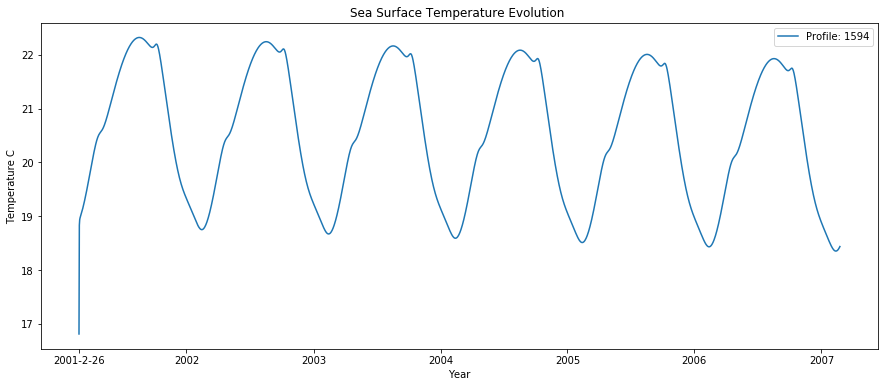

In [95]:
follow_x_plot(daysx2,tempx2,int(prof2),step = 1)

In [20]:
y1 = pd.read_pickle("data/KS-p_100-10/y-KS-p_100-10.pkl")
y1

array([[13.98700047, 33.16059875],
       [ 4.07000017, 33.40319824],
       [ 5.33699989, 33.43439865],
       ...,
       [ 4.58900023, 33.11700058],
       [ 7.40999985, 33.52799988],
       [ 7.3210001 , 33.40999985]])

In [21]:
y1 = pd.read_pickle("data/KS-p_100-10/y_train_ks100_10.pkl")
y1

array([[ 8.56499958, 33.6853981 ],
       [ 9.82600021, 33.63579941],
       [ 5.30999994, 33.49459839],
       ...,
       [ 2.13800001, 33.05699921],
       [ 7.5170002 , 33.06800079],
       [ 7.11000013, 33.11700058]])